## Question to answer:
## Is it possible to cluster and get some insights about hockey players by using statistics from games and information as height/weight?

### Dataset: https://www.kaggle.com/datasets/martinellis/nhl-game-data
### Source of inspiration: 
### https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering,
### https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

#### Importing libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import warnings

warnings.filterwarnings('ignore')

#### Loading data

In [28]:
player_stats = pd.read_csv('archive\game_skater_stats.csv')
player_info = pd.read_csv('archive\player_info.csv')

#### Selecting variables that could be of use, and dropping variables that will not add any value.

In [29]:
player_stats = player_stats.groupby('player_id')['timeOnIce', 'goals', 'assists', 'shots', 'hits', 'blocked', 'plusMinus', 'powerPlayTimeOnIce', 'shortHandedTimeOnIce'].sum().reset_index()

In [30]:
player_info.drop(['birthCity', 'birthDate', 'birthStateProvince', 'height'], axis=1, inplace=True)

#### merging the two dataframes into one dataframe

In [31]:
data = pd.merge(player_stats, player_info)

In [32]:
data.head()

,player_id,timeOnIce,goals,assists,shots,hits,blocked,plusMinus,powerPlayTimeOnIce,shortHandedTimeOnIce,firstName,lastName,nationality,primaryPosition,height_cm,weight,shootsCatches
0,8444894,51806,11,12,66,0.0,0.0,-3,6136,541,Greg,Adams,CAN,LW,193.04,196.0,L
1,8444919,232930,4,37,174,0.0,0.0,22,21945,18160,Tommy,Albelin,SWE,D,187.96,195.0,L
2,8445000,322029,88,74,696,0.0,0.0,-46,76195,33846,Dave,Andreychuk,CAN,LW,193.04,225.0,R
3,8445176,214915,59,82,532,0.0,0.0,-19,52334,4126,Donald,Audette,CAN,RW,172.72,191.0,R
4,8445266,329428,7,23,185,0.0,0.0,2,1451,73885,Murray,Baron,CAN,D,190.50,236.0,L


### Feature Engineering

#### The statistics is accumulated by each players whole career, I will therefore divide by how much each player have been on the ice to be able to compare players with each other.

In [33]:
data['goalsPerTime'] = (data['goals'] / data['timeOnIce'])
data['assistsPerTime'] = (data['assists'] / data['timeOnIce'])
data['shotsPerTime'] = data['shots'] / data['timeOnIce']
data['hitsPerTime'] = data['hits'] / data['timeOnIce']
data['blockedPerTime'] = data['blocked'] / data['timeOnIce']

#### Dropping unnecessary features

In [34]:
data.drop(['timeOnIce', 'goals', 'assists', 'shots', 'hits', 'blocked', 'plusMinus', 'player_id', 'firstName', 'lastName'], axis=1, inplace=True)

#### Handling of missing values.

In [35]:
data.isna().sum()

powerPlayTimeOnIce      0
shortHandedTimeOnIce    0
nationality             2
primaryPosition         0
height_cm               0
weight                  0
shootsCatches           7
goalsPerTime            0
assistsPerTime          0
shotsPerTime            0
hitsPerTime             0
blockedPerTime          0
dtype: int64

#### I will just drop the rows since there is few NA-values compared to the whole dataset.

In [36]:
data.dropna(inplace=True)

#### Creating  a list of categorical variables and transforming these to numerical.

In [37]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

In [38]:
data.shape

(3344, 12)

In [39]:
data.describe()

,powerPlayTimeOnIce,shortHandedTimeOnIce,nationality,primaryPosition,height_cm,weight,shootsCatches,goalsPerTime,assistsPerTime,shotsPerTime,hitsPerTime,blockedPerTime
count,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000
mean,28530.063397,22654.667165,12.346890,1.312799,185.580269,201.520335,0.364533,0.000120,0.000199,0.001524,0.000882,0.000401
std,52183.757131,37663.206691,9.847925,1.061215,5.353692,15.805169,0.481371,0.000128,0.000148,0.000708,0.001190,0.000525
min,0.000000,0.000000,0.000000,0.000000,162.560000,154.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326.750000,131.000000,4.000000,0.000000,182.880000,190.000000,0.000000,0.000025,0.000109,0.001053,0.000000,0.000000
50%,3567.500000,3310.000000,5.000000,1.000000,185.420000,200.000000,0.000000,0.000098,0.000188,0.001513,0.000422,0.000228
75%,29835.000000,31083.500000,24.000000,2.000000,187.960000,211.000000,1.000000,0.000188,0.000274,0.001946,0.001360,0.000648
max,402799.000000,354234.000000,26.000000,3.000000,205.740000,265.000000,1.000000,0.003145,0.001592,0.009709,0.008688,0.009524


#### There is a big variation in the values between the features, so to be able to visualize and detect outliers for all features in one chart like below and later run the data with PCA and KMeans algorithm, the data have to be normalized. So therefore I am going to normalize the data using the StandardScaler.

In [40]:
scale = StandardScaler()
scaled_data = pd.DataFrame(scale.fit_transform(data))

# Adding feature names to the scaled_data dataframe 
scaled_data.set_axis(data.columns,axis=1,inplace=True)

#### Visualizing distribution of all features

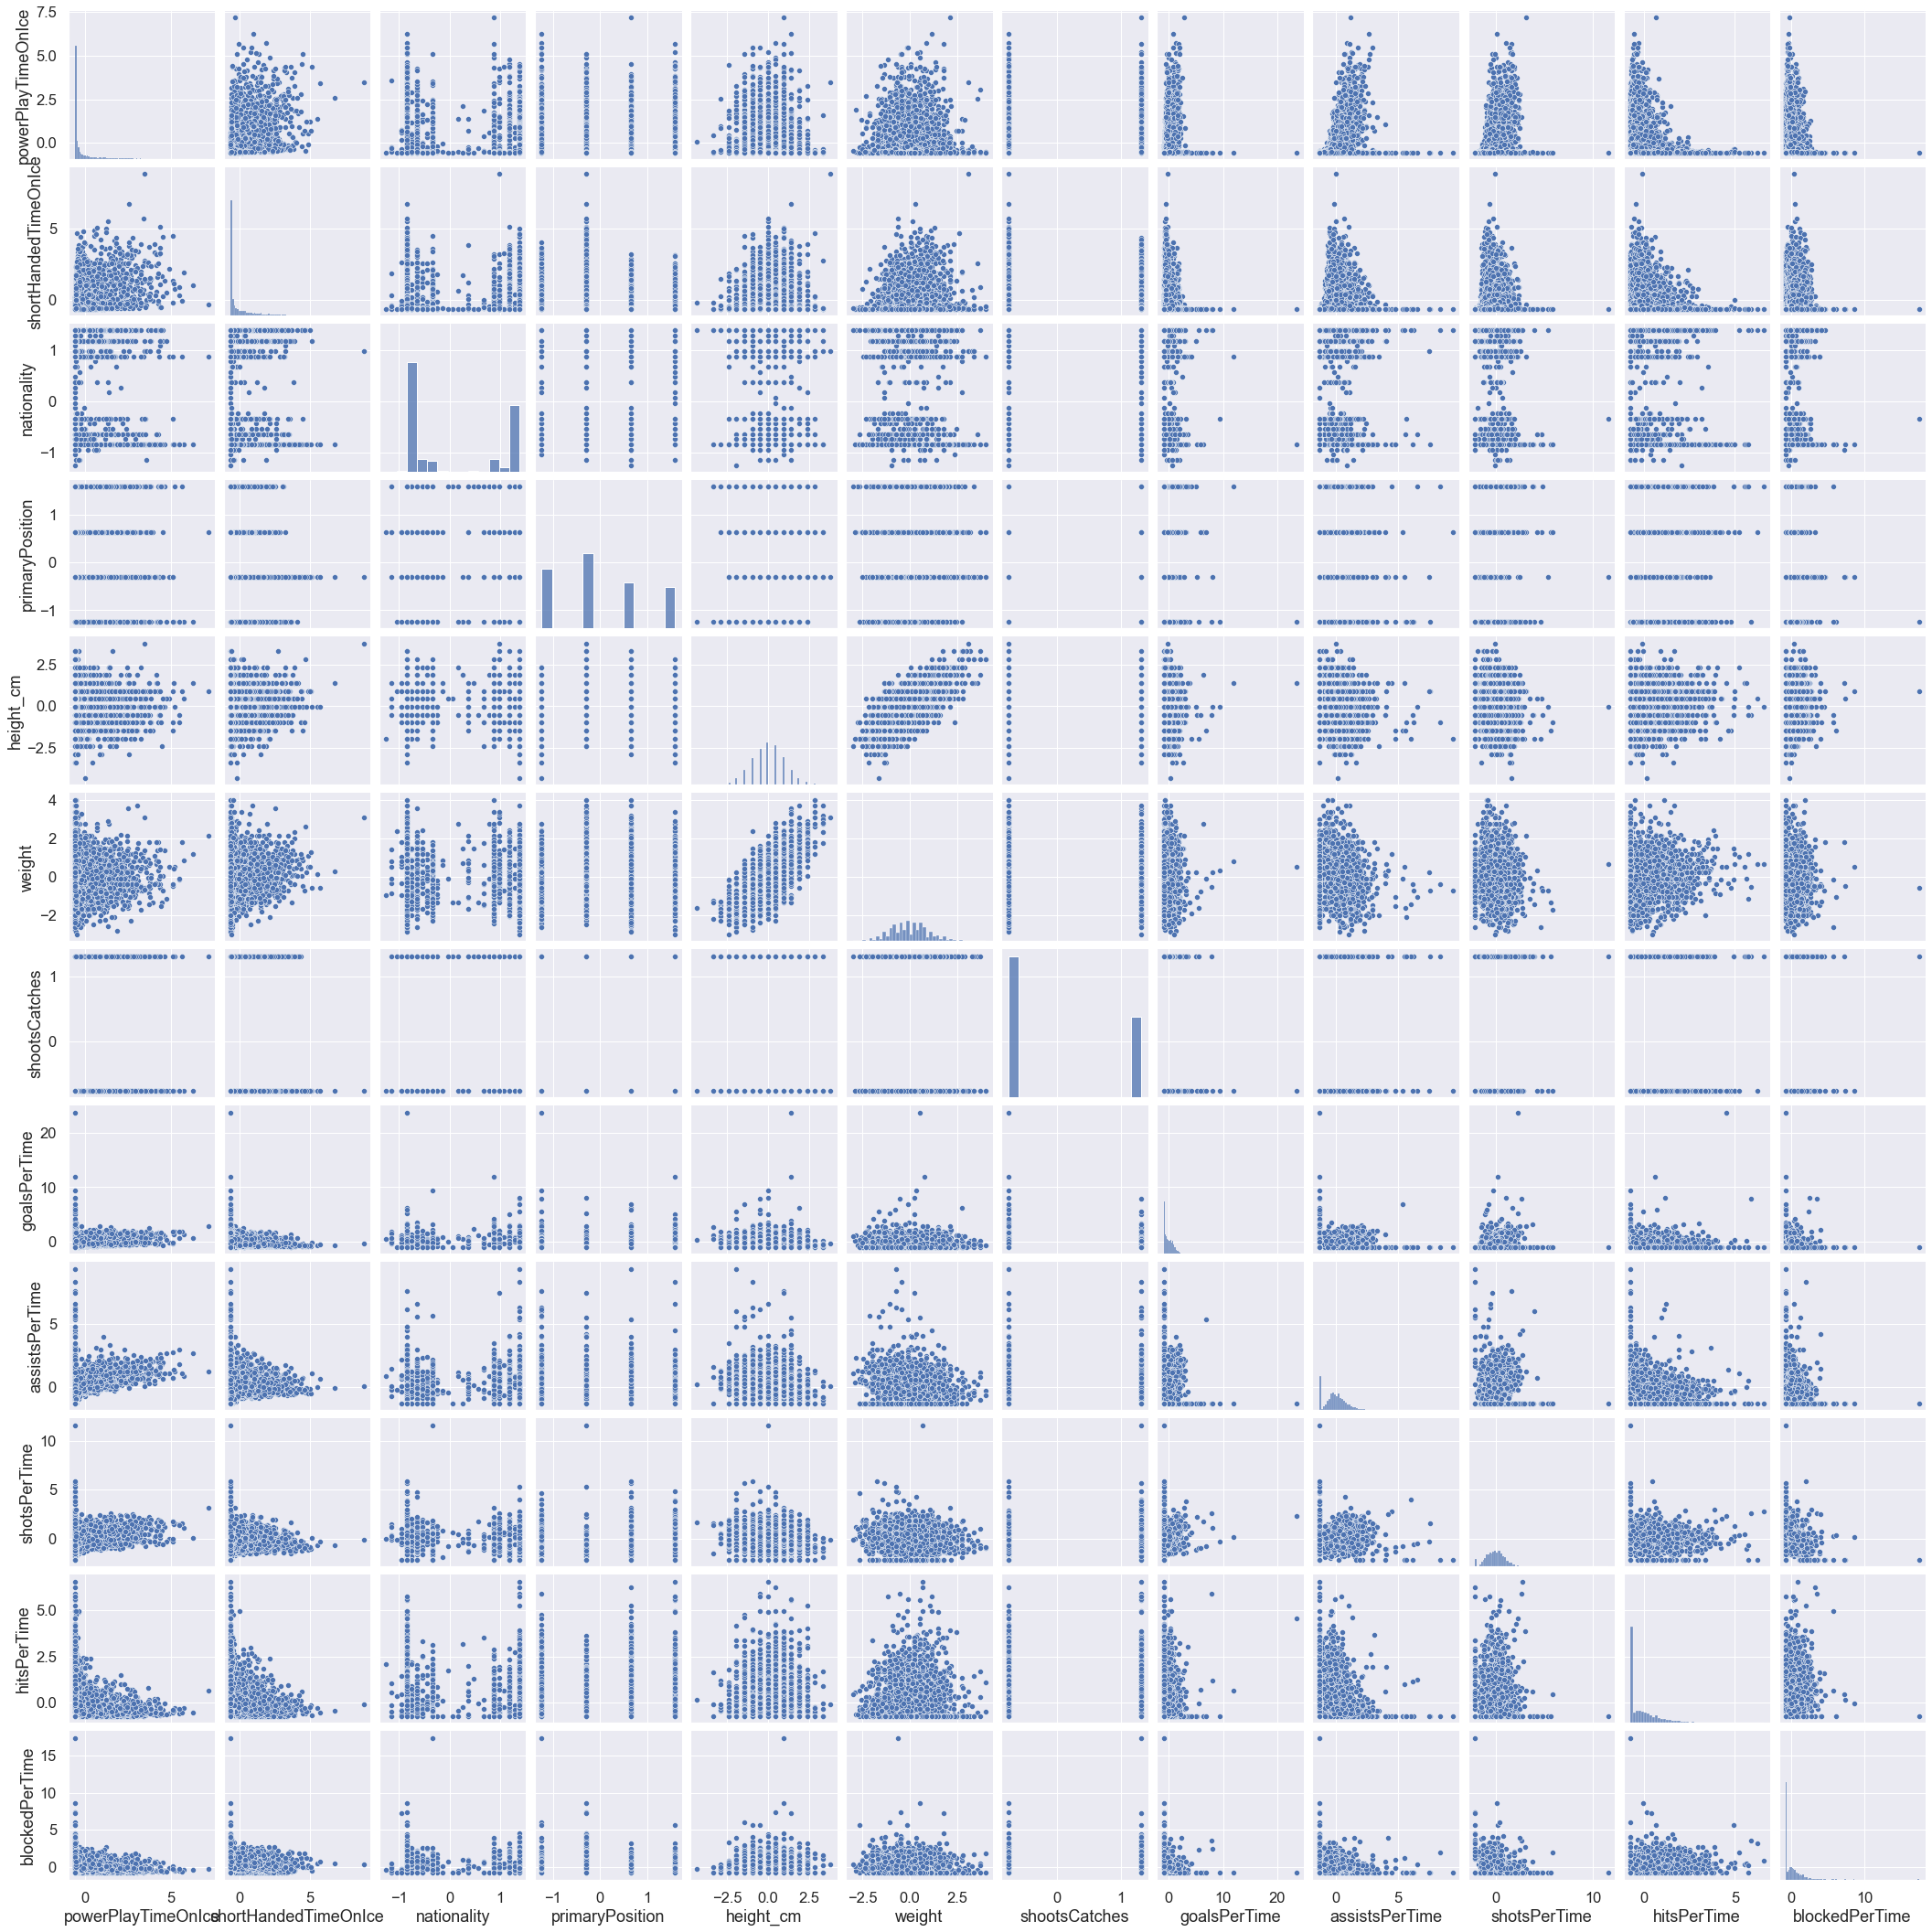

In [41]:
sns.pairplot(scaled_data);

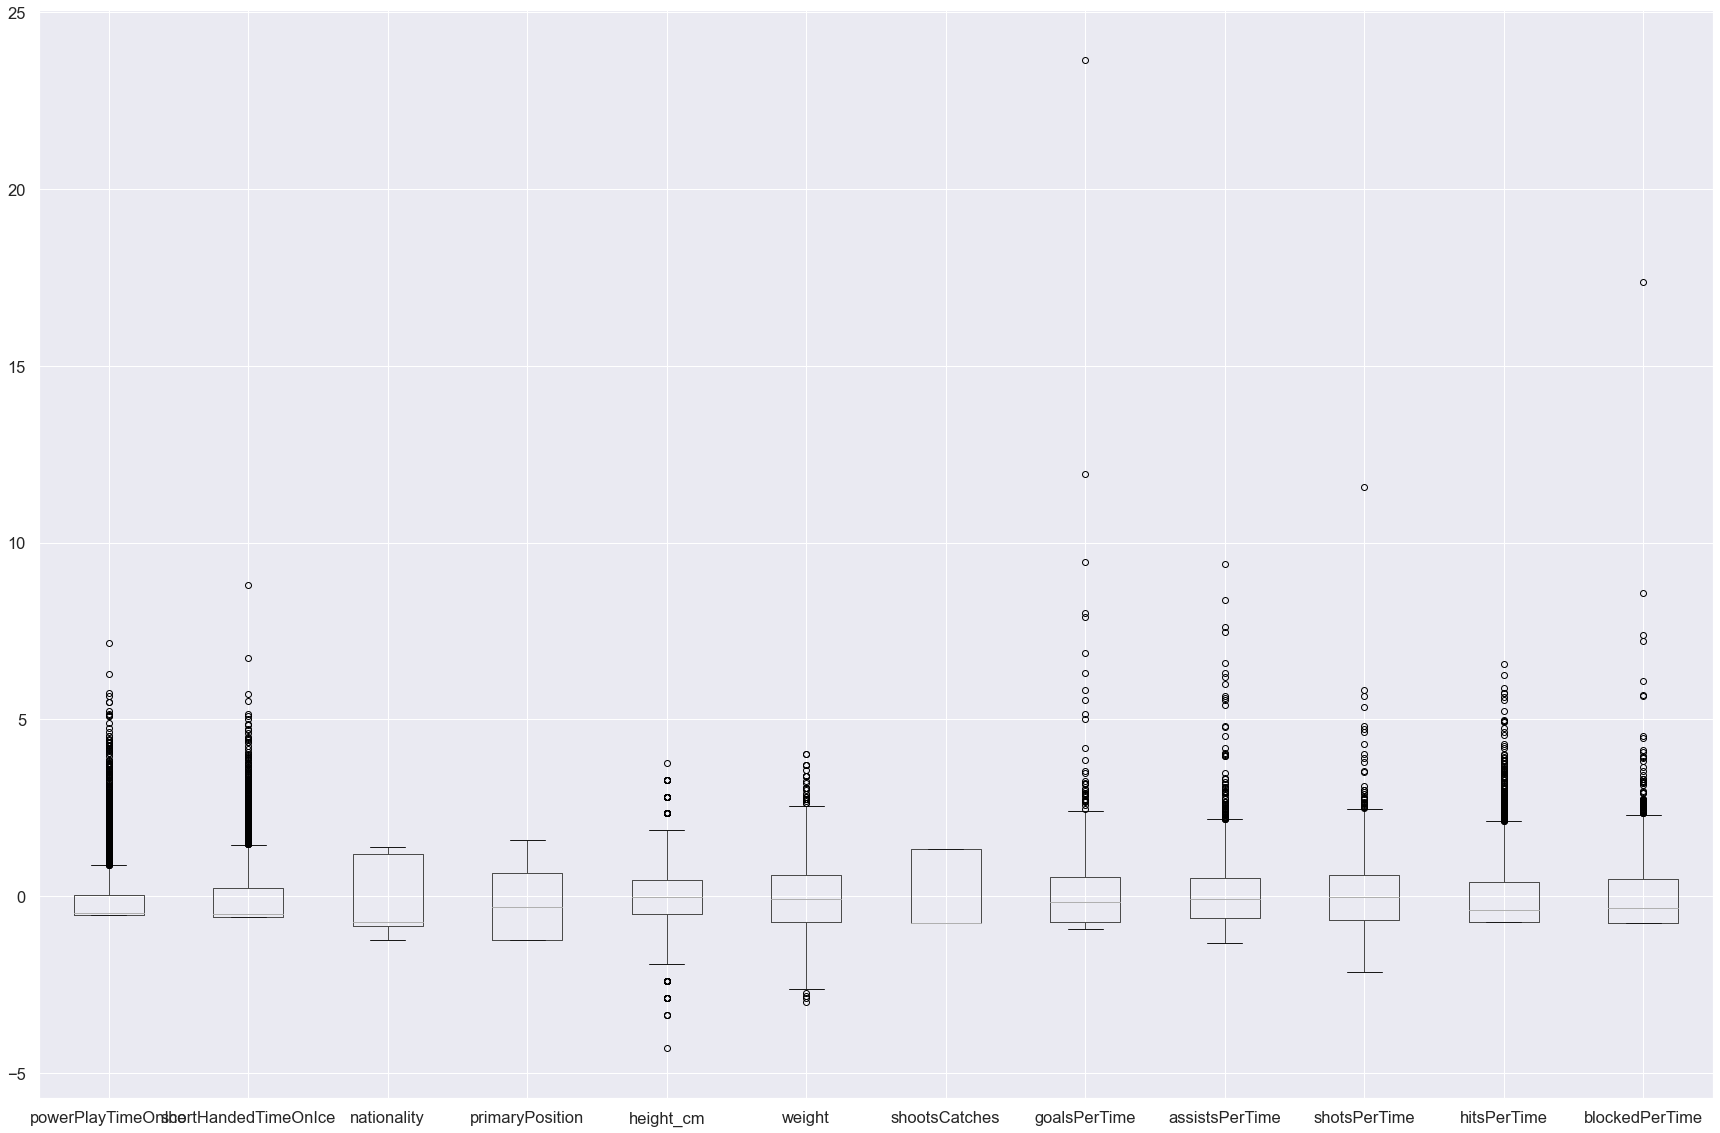

In [42]:
scaled_data.boxplot(figsize=(30,20))
plt.show()

#### Dropping outliers above 8.

In [43]:
scaled_data.drop(scaled_data[scaled_data.values > 8].index, inplace=True)

#### Using T-SNE to visualize clusters

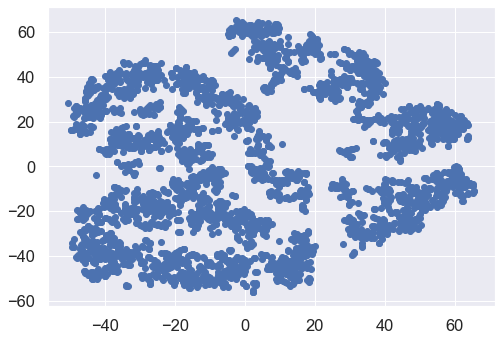

In [44]:
model = TSNE(random_state=1)
transformed = model.fit_transform(scaled_data)
x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x,y)
plt.show()

#### At a first glance it looks like there are three of maybe four large clusters, but there could also be more and smaller clusters.
#### I will use PCA to reduce the dimensions to see if it is possible to see any improvements.

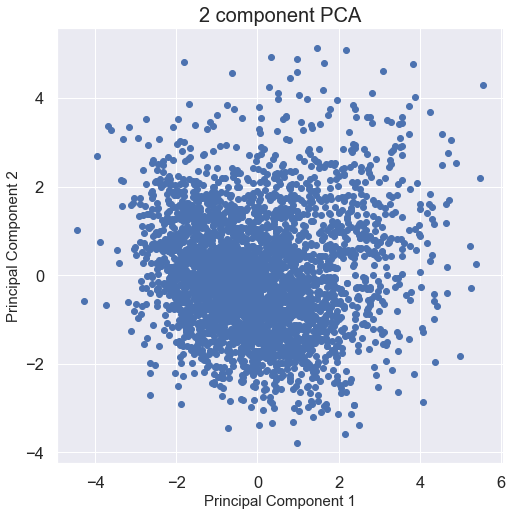

In [45]:
pca = PCA(n_components=2, random_state=1)
pca.fit(scaled_data)
pca_df = pd.DataFrame(pca.transform(scaled_data), columns=(['Principal Component 1', 'Principal Component 2']))
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(pca_df['Principal Component 1'],
            pca_df['Principal Component 2']);

### After reduction of dimensions using PCA I will run the TSNE again but this time with the pca dataframe.
### As we can see below, now there are four or maybe five more distinct clusters.

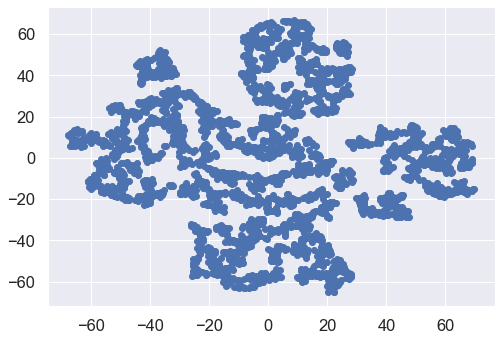

In [46]:
model = TSNE(random_state=1)
transformed = model.fit_transform(pca_df)
x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x,y)
plt.show()

#### Before using KMeans algorithm to cluster the data, I will use KElbowVisualizer to find out the optimal number of clusters. Below, the graph shows the steepnes of the line is flattening out at k=4, so I will therefore use 4 clusters in the algorithm.

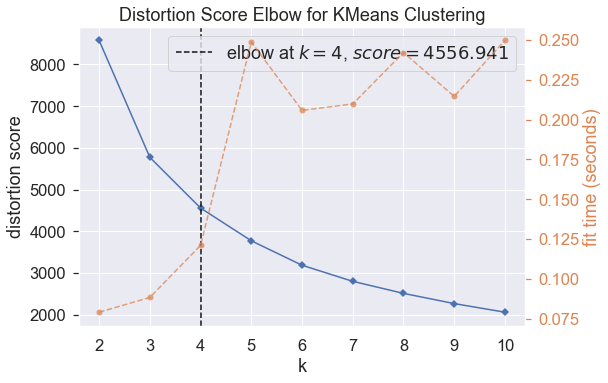

In [47]:
Elbow_M = KElbowVisualizer(KMeans(random_state=1), k=10)
Elbow_M.fit(pca_df)
Elbow_M.show();

In [48]:
kmeans = KMeans(n_clusters=4, random_state=1)
clusters_predicted = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2']])
pca_df['Cluster'] = clusters_predicted

# Adding the Cluster variables to the original dataframe to be able to visualize and profile the clusters.
scaled_data["Cluster"] = clusters_predicted

#### Creating dataframes for each cluster and visualizing the clusters in a scatterplot

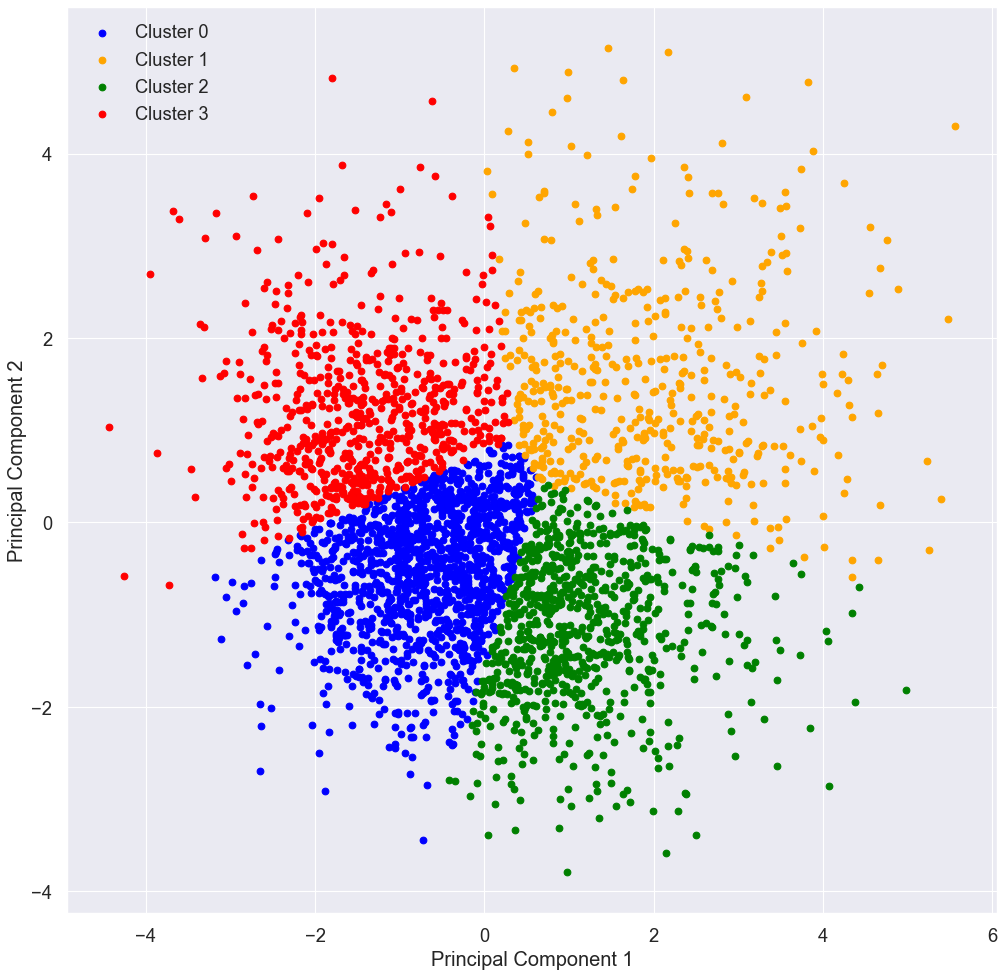

In [49]:
df1 = pca_df[pca_df.Cluster == 0]
df2 = pca_df[pca_df.Cluster == 1]
df3 = pca_df[pca_df.Cluster == 2]
df4 = pca_df[pca_df.Cluster == 3]

figure(figsize=(15, 15), dpi=80)
plt.scatter(df1['Principal Component 1'], df1['Principal Component 2'], color='blue', label='Cluster 0')
plt.scatter(df2['Principal Component 1'], df2['Principal Component 2'], color='orange', label='Cluster 1')
plt.scatter(df3['Principal Component 1'], df3['Principal Component 2'], color='green', label='Cluster 2')
plt.scatter(df4['Principal Component 1'], df4['Principal Component 2'], color='red', label='Cluster 3')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend();

#### Plotting distribution of clusters

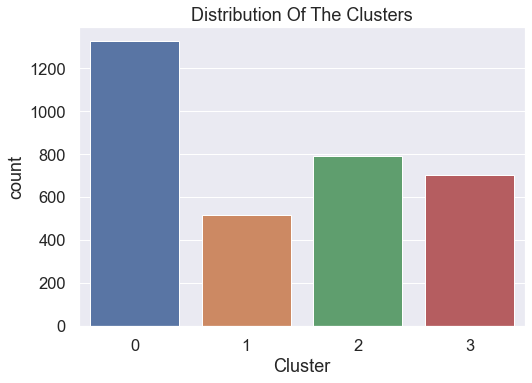

In [50]:
pl = sns.countplot(x=scaled_data["Cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show();

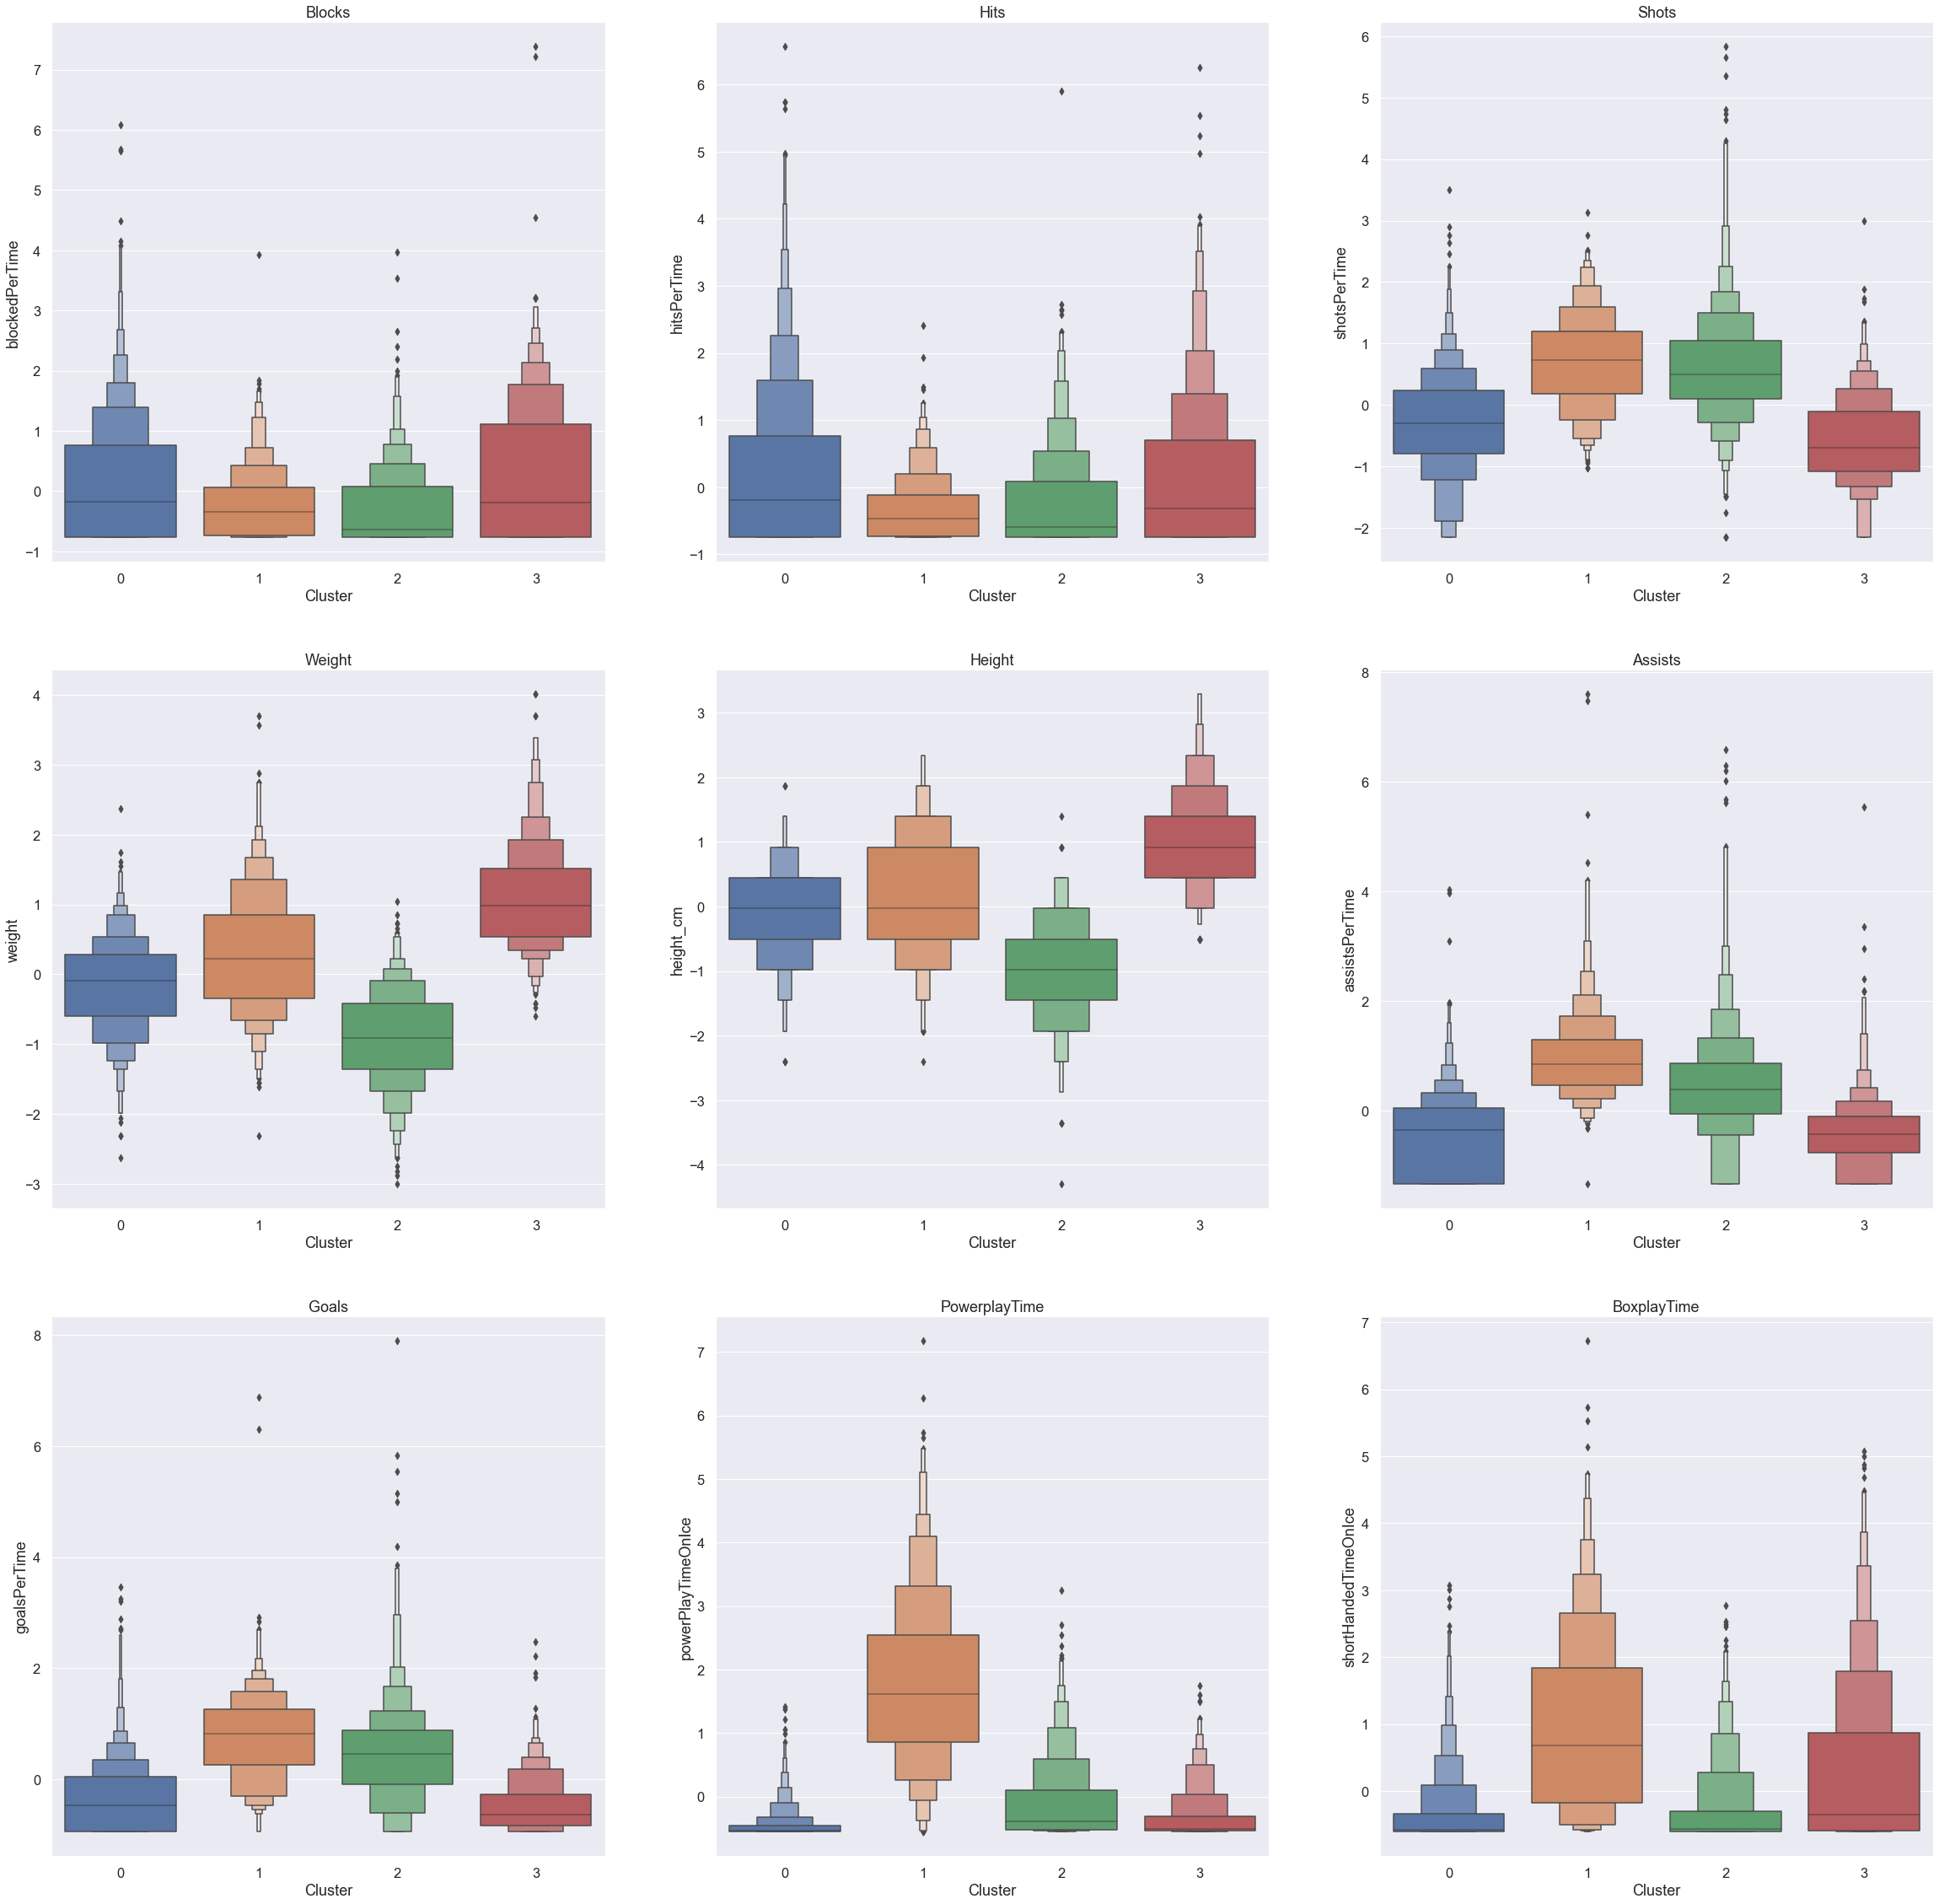

In [51]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(3, 3, figsize=(40,40))

sns.boxenplot(data=scaled_data, x='Cluster', y='blockedPerTime', ax=axes[0,0]).set_title('Blocks')
sns.boxenplot(data=scaled_data, x='Cluster', y='hitsPerTime', ax=axes[0,1]).set_title('Hits')
sns.boxenplot(data=scaled_data, x='Cluster', y='shotsPerTime', ax=axes[0,2]).set_title('Shots')
sns.boxenplot(data=scaled_data, x='Cluster', y='weight', ax=axes[1,0]).set_title('Weight')
sns.boxenplot(data=scaled_data, x='Cluster', y='height_cm', ax=axes[1,1]).set_title('Height')
sns.boxenplot(data=scaled_data, x='Cluster', y='assistsPerTime', ax=axes[1,2]).set_title('Assists')
sns.boxenplot(data=scaled_data, x='Cluster', y='goalsPerTime', ax=axes[2,0]).set_title('Goals');
sns.boxenplot(data=scaled_data, x='Cluster', y='powerPlayTimeOnIce', ax=axes[2,1]).set_title('PowerplayTime')
sns.boxenplot(data=scaled_data, x='Cluster', y='shortHandedTimeOnIce', ax=axes[2,2]).set_title('BoxplayTime');

## Profiling of clusters and conclusion

#### Cluster 0: This is the cluster where most of the players fall into, they are of average height and weight, they tend to block shots and tackle more than shooting and scoring points. This cluster could be classified as "average" players who probably would fit into the 2nd or 3rd line.
#### Cluster 1: This cluster includes players who are heavier and taller than just above average, they almost do not block shots at all, which indicates they are not spending a lot of time in the defensive zone, they shoot and score most goals of everybody and plays most time of everyone in specialteams(powerplay/boxplay) all this indicates they are the stars of their teams, typical 1st line players.
#### Cluster 2: This cluster includes players who are short in length, light weighted, they tend to assist to goals the most and shoots a lot but still do not score the most goals. This cluster could be classified as offensive players in a 1st line that is supporting the top scoring players with passes.
#### Cluster 3: This cluster includes players who are tall, heavy weighted, tackles the most, does not play much time in Powerplay but a lot of time in boxplay. They also tend to score the least points. This cluster could be classified as big, defensive and aggressive players. Possibly a typical 4th line player who is sent in to kill time and make the opponent tired.
#### I would say there is some possibility to cluster and get some insights based on these statistics and using of unsupervised machine learning algos.